# 回测

# 从整体单回测周期角度看

### 回测

In [1]:
import pandas as pd
import numpy as np
from tqdm import notebook

#用于csv文件的存储和读取
dataset_name = 'total'
panel = pd.read_csv(f'{dataset_name}_panel.csv', parse_dates=['trade_date'], index_col=['code','trade_date'])
index_data = pd.read_csv('index_data.csv', parse_dates=['trade_date'], index_col=['index_code','trade_date'])
index_content_data = pd.read_csv('index_content_data.csv', index_col='index')

AMB_e_df = pd.read_csv('AMB_5e.csv', parse_dates=['trade_date'], index_col=['code', 'trade_date'])

RV_df = pd.read_csv('RV_1day.csv', parse_dates=['trade_date'], index_col=['trade_date'])
RV_df = RV_df.stack().reset_index(level=1).rename(columns={'level_1':'code', 0:'RV'}).set_index('code', append=True)
RV_df = RV_df.swaplevel().sort_index()

# 时间刻度
timerange = panel.index.get_level_values(1).unique()
timerange_n = pd.Series(timerange, index=timerange)

panel = panel[~panel.index.get_level_values(level=0).str.startswith(('200','201','900'))] # 去掉B股

panel = panel.join(AMB_e_df)
panel = panel.join(RV_df)

# RV有缺失需要补齐
panel[['RV']] = panel[['RV']].groupby('code').apply(lambda x: x.interpolate(method='linear', \
                                                                limit_direction='both')).reset_index(level=0, drop=True)

In [2]:
na = panel.loc[(slice(None), slice('2021-02-01', '2023-06-30')), :].isna().sum().sum() == 0
print(f'Na值存在：{na}')

Na值存在：True


In [3]:
# %%time
# # 参数设置
# backtime_s = '2022-01-01'
# backtime_e = '2023-06-30'
# backtime_s_before_one = pd.to_datetime(backtime_s)-pd.Timedelta(days=1) # 用于计算np.sqtn(ln(t)/Nt)中的时间间隔t

# 筛选指数数据
# 沪深300指数 (000300)、中证小盘500指数 (000905)、中证800指数 (000906)、中证1000指数 (000852)、中证全指指数 (000985)
index_code = 300
index_data = index_data.loc[(index_code, slice(None)),:]
#*******************************************************
# 筛选股票数据

# #按照板块过滤
# # 1、股票代码前三位为000、001：深交所主板
# # 2、股票代码前两位为60：上交所主板
# # 3、股票代码前三位为002、003：中小板
# # 4、股票代码前三位为300：创业板
# filter_str = ('000', '001', '60', '002', '003', '300')
# panel = panel[panel.index.get_level_values('code').str.startswith(filter_str)]
# Wx_df = Wx_df[Wx_df.index.get_level_values('code').str.startswith(filter_str)]

# 按照指数成分股过滤
# 沪深300指数 (000300)、中证小盘500指数 (000905)、中证800指数 (000906)、中证1000指数 (000852)、中证全指指数 (000985)
filter_str = index_content_data['985'].dropna().values
filter_str = tuple(filter_str)
panel = panel[panel.index.get_level_values('code').str.startswith(filter_str)]

# 滑点、手续费和印花税
# 买入要考虑滑点和手续费
# 卖出要考虑滑点、手续费和印花税
commission = 0.0003
stamp_duty = 0.001
slippage = 0.001

CPU times: total: 1min 9s
Wall time: 1min 11s


In [4]:
print(f'股票个数：{len(panel.index.get_level_values(level=0).unique())}')
print(f'回测期数：{len(panel.index.get_level_values(level=1).unique())}')

股票个数：2680
回测期数：846


In [5]:
# 基于Ht的轮盘赌选股
def get_portfolio_byroulette(Ht, num_pool, num_portfolio): # 先通过轮盘赌的方式取出股票池，再从池子中选出最好的一部分    
    Pr = np.exp(Ht)/np.exp(Ht).sum()
    Pr_cumsum = Pr.cumsum(axis=0)
    random_num = np.random.random(num_pool)
    random_index = Pr_cumsum.index[Pr_cumsum.searchsorted(random_num, side='left')] # 找出某个元素放在哪个位置上才能保持原有的排列顺序
    unique_index, counts = np.unique(random_index, return_counts=True)
    index_Series = pd.Series(data=counts, index=unique_index).nlargest(num_portfolio)
    portfolio = index_Series.index.to_list()
    return portfolio

In [6]:
roll_num = 5
# 基于对数收益率的方法
panel['cum_ret'] = np.log(panel.close).groupby('code').diff(roll_num)
index_data['cum_ret'] = np.log(index_data.close).groupby('index_code').diff(roll_num)
panel['mean_log_ret'] = panel.log_ret.groupby('code').rolling(window=roll_num).mean().reset_index(level=0, drop=True)
index_data['log_ret'] = np.log(index_data.close).groupby('index_code').diff()
index_data['mean_log_ret'] = index_data.log_ret.groupby('index_code').rolling(window=roll_num).mean().reset_index(level=0, drop=True)

# 计算5日已实现收益率
panel['cum_RV'] = panel.RV.groupby('code').rolling(window=5).sum().reset_index(level=0, drop=True)

In [7]:
code_num = panel.RV.index.get_level_values(level=0).unique().shape[0]
date_num = panel.RV.index.get_level_values(level=1).unique().shape[0]
all_num = panel.RV.index.shape[0]

print(f'股票数量：{code_num}')
print(f'日期数量：{date_num}')
print(f'总数：{all_num}')
print(f'是否相等：{all_num == code_num*date_num}')

股票数量：2680
日期数量：846
总数：2267280
是否相等：True


In [27]:
from tqdm import notebook

# 参数设置
backtime_s = '2022-01-01'
backtime_e = '2023-06-30'
backtime_s_before_one = pd.to_datetime(backtime_s)-pd.Timedelta(days=1) # 用于计算np.sqtn(ln(t)/Nt)中的时间间隔t

gamma = 1
beta = 0.05
alpha_max = 0.15
threshold = 0.06
delta = 1
Wc = 0.1

cash = 1000000 # 投资组合初始现金
cash_index = 1000000 # 投资指数初始现金
num_pool = 100000 # 轮盘赌次数
num_portfolio = 30 # 投资组合个数
num_repositon = 9 # 调仓个数
loop = 10 # 调参期数

cash_dict = {} # 记录投资组合的资金变化
cash_index_dict = {} # 记录投资指数的资金变化
portfolio_dict = {} # 记录投资成分股的变化
portfolio_price_list = [] # 记录组合成分股的价格变化
Params_list = [] # 记录参数的变化

#获得生成threshold需要计算累计std_df
panel_copy = panel.copy(deep=True)

panel_copy.sort_index(level=[0, 1], inplace=True) # 按多层索引排序
t_before = timerange_n.iloc[(timerange_n.index.get_loc(timerange_n[backtime_s:backtime_e].iloc[0])) - 245] # 以回测开始前一年为所有回归的时间起点

i = 0 # 轮数变量
o = 1 # 初始化变量
for t in notebook.tqdm(timerange_n[backtime_s:backtime_e]):

    # 取出前一天的数据
    t_before_one = timerange_n.iloc[timerange_n.index.get_loc(t)-1]
    
    # 取出该天的数据
    panel_swap_one = panel_copy.loc[(slice(None),t), ].reset_index(level=1, drop=True)
    panel_swap_before_one = panel_copy.loc[(slice(None),t_before_one), ].reset_index(level=1, drop=True)
    
    i += 1
    if i == 1: # 每轮10次，第1次开始重新计算Ht
        
        # 初始化偏好值Ht
        AMB_e = panel_swap_one.loc[slice(None), 'AMB_5e']
        alpha = AMB_e.map(lambda x: alpha_max if x<= threshold else alpha_max + delta * (1 - np.exp(x - threshold)))  
        AMB_e_alpha = np.multiply(AMB_e, alpha)
        
        # 生成Wc_sqrt_lnt_Nt
        sqrt_lnt_Nt = np.sqrt(np.log((t - backtime_s_before_one).days)/panel_swap_one['trade_date_from_IPO'])
        Wc_sqrt_lnt_Nt =  np.multiply(Wc, sqrt_lnt_Nt)

        # 组合
        uncertainty = AMB_e_alpha + Wc_sqrt_lnt_Nt
        gamma_uncertainty = gamma * uncertainty

        # 计算Utility
        cum_ret = panel_swap_one.loc[slice(None), 'cum_ret']
        cum_RV = panel_swap_one.loc[slice(None), 'cum_RV']
        Utility = cum_ret/cum_RV

        Ht = Utility + gamma_uncertainty
        
        if o == 1: # 初始化选出投资组合，只运行一次

            Ht = np.clip(Ht, Ht.quantile(0.9), Ht.quantile(0.95))
            Ht = Ht.replace(Ht.min(), 0)

            # #基于整体的轮盘赌
            portfolio = get_portfolio_byroulette(Ht, num_pool, num_portfolio)
            if len(portfolio) < num_portfolio:
                print(f'初始投资组合个数：{len(portfolio)}')
                break
            
            portfolio_dict[t] = portfolio # 记录投资组合成分股
            price_start = panel_swap_one.loc[portfolio, 'close']
            buy_price_start = price_start * (1 + slippage) # 买入价格增加滑点
            buy_cash = cash / (1 + commission) # 扣除佣金
            num = (buy_cash/num_portfolio)/buy_price_start # 计算调仓数量
            
            cash_dict[t] = cash # 记录资金量变化, 只记录未进行买入的资金量
            price_start.name = t # 记录组合成分股的价格变化
            
            # 指数投资
            index_price = index_data.loc[(index_code, t), 'close']
            num_index = cash_index/index_price
            cash_index_dict[t] = cash_index # 记录投资指数的资金量变化
            
            o = 0 # 归零保证只在回测开始时运行一次
            
    elif 2 <= i < loop:
        # 将Ht用softmax转化为概率
        Pr = np.exp(Ht)/np.exp(Ht).sum()
        I = 1
        
        # 收益最大化的梯度提升
        # 与不含t日的指数收益率比较更新Ht
        ret_series = panel_swap_one['cum_ret']
        index_ret = index_data.loc[(index_code, t_before_one), 'cum_ret']
        # 更新Ht
        Ht_update = Ht + beta * (ret_series - index_ret) * (I - Pr)
        Ht = Ht_update
        
        # 计算本轮投资组合的价格变化
        price_end = panel_swap_one.loc[portfolio, 'close']
        cash = (num * price_end).sum()
        cash_dict[t] = cash # 记录资金量变化, 只记录未进行买入的资金量
    
        # 计算本轮投资指数的价格变化
        index_price = index_data.loc[(index_code, t), 'close']
        cash_index = num_index*index_price
        cash_index_dict[t] = cash_index # 记录投资指数的资金量变化
    
    elif i == loop: # 调仓期选出新的投资组合再投资

        # 计算本轮资金
        price_end = panel_swap_one.loc[portfolio, 'close']
        cash = (num * price_end).sum()
        cash_dict[t] = cash # 记录资金量变化, 只记录未进行买入的资金量

        # 保存投资组合成分股的价格信息
        price_end.name = t # 记录组合成分股的价格变化
        price_df = pd.concat([price_start, price_end], axis=1)
        price_df['trade_date'] = t
        price_df.set_index('trade_date', append=True, inplace=True)
        price_df = price_df.swaplevel()
        portfolio_price_list.append(price_df)

        # 选出投资组合再投资
        # 将原有投资组合
        # 将Ht用softmax转化为概率
        Pr = np.exp(Ht)/np.exp(Ht).sum()
        
        # 调仓
        Reserved_portfolio = Pr[portfolio].sort_values(ascending=False)[:-num_repositon].index.to_list() # Pr值较好的21只股票保留
        Remove_portfolio = [i for i in portfolio if i not in Reserved_portfolio] # Pr值最差的9只股票准备剔除
        
        # 获得调仓的资金(卖出股票)
        Reposition_cash = (num[Remove_portfolio]*(panel_swap_one.loc[Remove_portfolio, 'close'])*
                           (1 - slippage)*(1 - commission - stamp_duty)).sum()
        
        # # 基于整体的轮盘赌选出10只股票作为备选池
        # 增加一轮筛选剔除cum_ret小于零的索引

        # 只取前10%参与调仓
        Ht = np.clip(Ht, Ht.quantile(0.9), Ht.quantile(0.95))
        Ht = Ht.replace(Ht.min(), 0)
        Candidate_pool = get_portfolio_byroulette(Ht, num_pool, num_portfolio)
        
        # 将Pr值最大3只股票加入组合，同时避免入保留的股票重复
        # 得到用于调仓的股票
        Replace_portfolio = []
        n = 0
        for stock in Candidate_pool: 
            if stock not in Reserved_portfolio:
                Replace_portfolio.append(stock)       
                n += 1
                if n == num_repositon:
                    break
                    
        # 检测调仓股不够的情况            
        if n < num_repositon: # 有可能Ht的极大极小值，轮盘赌选不出3只以上的股票来替换
            print(f'调仓的个数为：{n},不够：{num_repositon}')
            break
        
        # 计算替换的股票购买数量
        # 计算买入佣金和手续费
        Replace_price_start = panel_swap_one.loc[Replace_portfolio, 'close']
        Replace_price_start *= (1 + slippage) # 买入价格增加滑点
        Reposition_cash = Reposition_cash/(1 + commission) # 买入股票前考虑调仓的佣金
        Reposition_num = (Reposition_cash/num_repositon)/Replace_price_start # 计算调仓数量

        # 新的投资组合的成分股和购买数量
        num = pd.concat([num.drop(Remove_portfolio), Reposition_num]) # 新组合资金的数量
        # 更新后投资组合
        Reserved_portfolio.extend(Replace_portfolio) # 将保留和要替换的股票结合在一起
        portfolio = Reserved_portfolio 

        if len(portfolio) < num_portfolio:
            print(f'投资组合的个数为：{len(portfolio)},不够：{num_portfolio}')
            break
        
        portfolio_dict[t] = portfolio # 将组合记录下来
        # 调仓后成分股的价格
        price_start = panel_swap_one.loc[portfolio, 'close']
        price_start.name = t # 记录组合成分股的价格变化

        # 投资指数的价格变化
        index_price = index_data.loc[(index_code, t), 'close']
        cash_index = num_index * index_price
        cash_index_dict[t] = cash_index # 记录投资指数的资金量变化
        
        i = 0 # 重置计数变量，表示开始新的一轮


    # 保存参数
    Params_df = pd.concat([pd.DataFrame(alpha).rename(columns={'AMB_5e':'alpha'}), 
                           # Wx, 
                           pd.DataFrame(AMB_e),
                           pd.DataFrame(AMB_e_alpha).rename(columns={'AMB_5e':'AMB_5e_alpha'}),
                           pd.DataFrame(sqrt_lnt_Nt).rename(columns={'trade_date_from_IPO':'sqrt_lnt_Nt'}),
                           pd.DataFrame(Wc_sqrt_lnt_Nt).rename(columns={'trade_date_from_IPO':'Wc_sqrt_lnt_Nt'}),
                           pd.DataFrame(uncertainty).rename(columns={0:'uncertainty'}),
                           pd.DataFrame(gamma_uncertainty).rename(columns={0:'gamma_uncertainty'}),
                           pd.DataFrame(panel_swap_before_one['ret']),
                           pd.DataFrame(panel_swap_before_one['cum_ret']),
                           pd.DataFrame(Ht).rename(columns={0:'Ht'})
                           ],
                           axis=1
                           )
    Params_df['trade_date'] = t
    Params_df.reset_index('code', inplace=True)
    Params_df.set_index(['trade_date', 'code'], inplace=True)
    Params_list.append(Params_df)


# 保存参数的大小比例
Params_df = pd.concat(Params_list, axis=0)
Params_df.to_csv(f'chart/{dataset_name}_amb_Params.csv')

# 选中次数排名
sort_count = pd.Series(pd.DataFrame(portfolio_dict).values.flatten()).value_counts()
# 组合成分股的价格变化
portfolio_price_df = pd.concat(portfolio_price_list)


  0%|          | 0/360 [00:00<?, ?it/s]

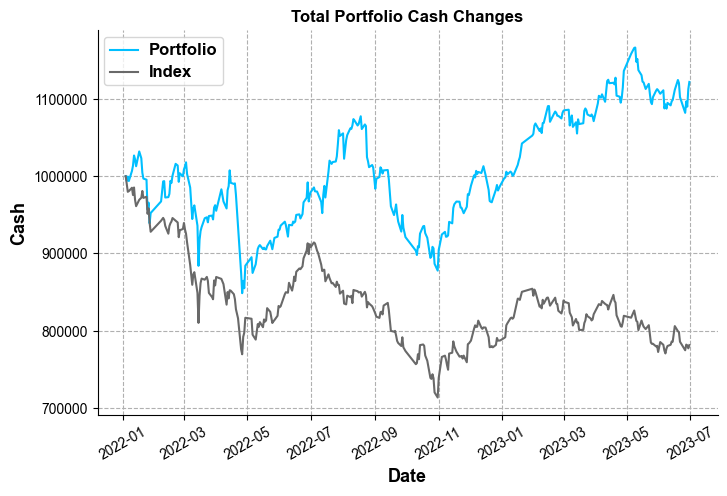

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

cash_df = pd.DataFrame([cash_dict]).T
cash_df.rename(columns={0:f'cash_gamma_{gamma}'}, inplace=True)
cash_index_df = pd.DataFrame([cash_index_dict]).T
cash_index_df.rename(columns={0:f'cash_gamma_{gamma}'}, inplace=True)

plt.rcParams['font.sans-serif'] = ['Arial']  # 如果要显示中文字体,则在此处设为：SimHei; 只显示英文字体设为：Arial
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

plt.figure(figsize=(8, 5))

plt.grid(linestyle="--")  # 设置背景网格线为虚线
ax = plt.gca() #表明设置图片的各个轴，plt.gcf()表示图片本身
ax.spines['top'].set_visible(False)  # 去掉上边框
ax.spines['right'].set_visible(False)  # 去掉右边框

plt.plot(cash_df, color='deepskyblue', label = "Portfolio")
plt.plot(cash_index_df, color='dimgrey', label = "Index")

plt.gca().yaxis.get_major_formatter().set_scientific(False)  # 禁用科学计数法
# plt.gca().yaxis.get_major_formatter().set_useOffset(False)   # 禁用偏移

# 旋转纵轴标签
plt.xticks(rotation=30)
plt.title(f'{dataset_name.title()} Portfolio Cash Changes', fontsize=12, fontweight='bold')  # 默认字体大小为12
plt.xlabel("Date", fontsize=13, fontweight='bold')
plt.ylabel("Cash", fontsize=13, fontweight='bold')

plt.legend()         #显示各曲线的图例
plt.legend(loc=2, scatterpoints=1, markerscale=0.3)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')  # 设置图例字体的大小和粗细

plt.savefig(f'chart/{dataset_name}_cash_change.svg', bbox_inches = 'tight', format='svg')  # 建议保存为svg格式,再用inkscape转为矢量图emf后插入word中
plt.show()

# 从整体多回测周期角度看

### 读取数据

In [1]:
import pandas as pd
import numpy as np
from tqdm import notebook

#用于csv文件的存储和读取
dataset_name = 'total'
panel = pd.read_csv(f'{dataset_name}_panel.csv', parse_dates=['trade_date'], index_col=['code','trade_date'])
index_data = pd.read_csv('index_data.csv', parse_dates=['trade_date'], index_col=['index_code','trade_date'])
index_content_data = pd.read_csv('index_content_data.csv', index_col='index')

AMB_e_df = pd.read_csv('AMB_5e.csv', parse_dates=['trade_date'], index_col=['code', 'trade_date'])

RV_df = pd.read_csv('RV_1day.csv', parse_dates=['trade_date'], index_col=['trade_date'])
RV_df = RV_df.stack().reset_index(level=1).rename(columns={'level_1':'code', 0:'RV'}).set_index('code', append=True)
RV_df = RV_df.swaplevel().sort_index()

# 时间刻度
timerange = panel.index.get_level_values(1).unique()
timerange_n = pd.Series(timerange, index=timerange)

panel = panel[~panel.index.get_level_values(level=0).str.startswith(('200','201','900'))] # 去掉B股

panel = panel.join(AMB_e_df)
panel = panel.join(RV_df)

# RV有缺失需要补齐
panel[['RV']] = panel[['RV']].groupby('code').apply(lambda x: x.interpolate(method='linear', \
                                                                limit_direction='both')).reset_index(level=0, drop=True)

### 参数设置

In [2]:
# %%time
# # 参数设置
# backtime_s = '2022-01-01'
# backtime_e = '2023-06-30'
# backtime_s_before_one = pd.to_datetime(backtime_s)-pd.Timedelta(days=1) # 用于计算np.sqtn(ln(t)/Nt)中的时间间隔t

# 筛选指数数据
# 沪深300指数 (000300)、中证小盘500指数 (000905)、中证800指数 (000906)、中证1000指数 (000852)、中证全指指数 (000985)
index_code = 300
index_data = index_data.loc[(index_code, slice(None)),:]
#*******************************************************
# 筛选股票数据

# #按照板块过滤
# # 1、股票代码前三位为000、001：深交所主板
# # 2、股票代码前两位为60：上交所主板
# # 3、股票代码前三位为002、003：中小板
# # 4、股票代码前三位为300：创业板
# filter_str = ('000', '001', '60', '002', '003', '300')
# panel = panel[panel.index.get_level_values('code').str.startswith(filter_str)]
# Wx_df = Wx_df[Wx_df.index.get_level_values('code').str.startswith(filter_str)]

# 按照指数成分股过滤
# 沪深300指数 (000300)、中证小盘500指数 (000905)、中证800指数 (000906)、中证1000指数 (000852)、中证全指指数 (000985)
filter_str = index_content_data['985'].dropna().values
filter_str = tuple(filter_str)
panel = panel[panel.index.get_level_values('code').str.startswith(filter_str)]

# 滑点、手续费和印花税
# 买入要考虑滑点和手续费
# 卖出要考虑滑点、手续费和印花税
commission = 0.0003
stamp_duty = 0.001
slippage = 0.001

CPU times: total: 1min 6s
Wall time: 1min 9s


In [3]:
roll_num = 5
# 基于对数收益率的方法
panel['cum_ret'] = np.log(panel.close).groupby('code').diff(roll_num)
index_data['cum_ret'] = np.log(index_data.close).groupby('index_code').diff(roll_num)
panel['mean_log_ret'] = panel.log_ret.groupby('code').rolling(window=roll_num).mean().reset_index(level=0, drop=True)
index_data['log_ret'] = np.log(index_data.close).groupby('index_code').diff()
index_data['mean_log_ret'] = index_data.log_ret.groupby('index_code').rolling(window=roll_num).mean().reset_index(level=0, drop=True)

# 计算5日已实现收益率
panel['cum_RV'] = panel.RV.groupby('code').rolling(window=5).sum().reset_index(level=0, drop=True)

### 函数设置

In [4]:
# 基于Ht的轮盘赌选股
def get_portfolio_byroulette(Ht, num_pool, num_portfolio): # 先通过轮盘赌的方式取出股票池，再从池子中选出最好的一部分    
    Pr = np.exp(Ht)/np.exp(Ht).sum()
    Pr_cumsum = Pr.cumsum(axis=0)
    random_num = np.random.random(num_pool)
    random_index = Pr_cumsum.index[Pr_cumsum.searchsorted(random_num, side='left')] # 找出某个元素放在哪个位置上才能保持原有的排列顺序
    unique_index, counts = np.unique(random_index, return_counts=True)
    index_Series = pd.Series(data=counts, index=unique_index).nlargest(num_portfolio)
    portfolio = index_Series.index.to_list()
    return portfolio

### 回测数据

In [5]:
from tqdm import notebook

def backtest(num_portfolio = 30, num_repositon = 9):
    backtime_s_before_one = pd.to_datetime(backtime_s)-pd.Timedelta(days=1) # 用于计算np.sqtn(ln(t)/Nt)中的时间间隔t
    gamma = 1
    beta = 0.05
    alpha_max = 0.15
    threshold = 0.06
    delta = 1
    Wc = 0.1


    
    cash = 1000000 # 投资组合初始现金
    cash_index = 1000000 # 投资指数初始现金
    num_pool = 100000 # 轮盘赌次数
    # num_portfolio = 30 # 投资组合个数
    # num_repositon = 9 # 调仓个数
    # loop = 10 # 调参期数
    
    cash_dict = {} # 记录投资组合的资金变化
    cash_index_dict = {} # 记录投资指数的资金变化
    portfolio_dict = {} # 记录投资成分股的变化
    portfolio_price_list = [] # 记录组合成分股的价格变化
    Params_list = [] # 记录参数的变化
    
    #获得生成threshold需要计算累计std_df
    panel_copy = panel.copy(deep=True)
    
    panel_copy.sort_index(level=[0, 1], inplace=True) # 按多层索引排序
    t_before = timerange_n.iloc[(timerange_n.index.get_loc(timerange_n[backtime_s:backtime_e].iloc[0])) - 245] # 以回测开始前一年为所有回归的时间起点
    
    i = 0 # 轮数变量
    o = 1 # 初始化变量
    for t in timerange_n[backtime_s:backtime_e]:
    
        # 取出前一天的数据
        t_before_one = timerange_n.iloc[timerange_n.index.get_loc(t)-1]
        
        # 取出该天的数据
        panel_swap_one = panel_copy.loc[(slice(None),t), ].reset_index(level=1, drop=True)
        panel_swap_before_one = panel_copy.loc[(slice(None),t_before_one), ].reset_index(level=1, drop=True)
        
        i += 1
        if i == 1: # 每轮10次，第1次开始重新计算Ht
            
            # 初始化偏好值Ht
            AMB_e = panel_swap_one.loc[slice(None), 'AMB_5e']
            alpha = AMB_e.map(lambda x: alpha_max if x<= threshold else alpha_max + delta * (1 - np.exp(x - threshold)))  
            AMB_e_alpha = np.multiply(AMB_e, alpha)
            
            # 生成Wc_sqrt_lnt_Nt
            sqrt_lnt_Nt = np.sqrt(np.log((t - backtime_s_before_one).days)/panel_swap_one['trade_date_from_IPO'])
            Wc_sqrt_lnt_Nt =  np.multiply(Wc, sqrt_lnt_Nt)
    
            # 组合
            uncertainty = AMB_e_alpha + Wc_sqrt_lnt_Nt
            gamma_uncertainty = gamma * uncertainty
    
            # 计算Utility
            cum_ret = panel_swap_one.loc[slice(None), 'cum_ret']
            cum_RV = panel_swap_one.loc[slice(None), 'cum_RV']
            Utility = cum_ret/cum_RV
    
            Ht = Utility + gamma_uncertainty
            
            if o == 1: # 初始化选出投资组合，只运行一次
    
                Ht = np.clip(Ht, Ht.quantile(0.9), Ht.quantile(0.95))
                Ht = Ht.replace(Ht.min(), 0)
    
                # #基于整体的轮盘赌
                portfolio = get_portfolio_byroulette(Ht, num_pool, num_portfolio)
                if len(portfolio) < num_portfolio:
                    print(f'初始投资组合个数：{len(portfolio)}')
                    break
                
                portfolio_dict[t] = portfolio # 记录投资组合成分股
                price_start = panel_swap_one.loc[portfolio, 'close']
                buy_price_start = price_start * (1 + slippage) # 买入价格增加滑点
                buy_cash = cash / (1 + commission) # 扣除佣金
                num = (buy_cash/num_portfolio)/buy_price_start # 计算调仓数量
                
                cash_dict[t] = cash # 记录资金量变化, 只记录未进行买入的资金量
                price_start.name = t # 记录组合成分股的价格变化
                
                # 指数投资
                index_price = index_data.loc[(index_code, t), 'close']
                num_index = cash_index/index_price
                cash_index_dict[t] = cash_index # 记录投资指数的资金量变化
                
                o = 0 # 归零保证只在回测开始时运行一次
                
        elif 2 <= i < loop:
            # 将Ht用softmax转化为概率
            Pr = np.exp(Ht)/np.exp(Ht).sum()
            I = 1
            
            # 收益最大化的梯度提升
            # 与不含t日的指数收益率比较更新Ht
            ret_series = panel_swap_one['cum_ret']
            index_ret = index_data.loc[(index_code, t_before_one), 'cum_ret']
            # 更新Ht
            Ht_update = Ht + beta * (ret_series - index_ret) * (I - Pr)
            Ht = Ht_update
            
            # 计算本轮投资组合的价格变化
            price_end = panel_swap_one.loc[portfolio, 'close']
            cash = (num * price_end).sum()
            cash_dict[t] = cash # 记录资金量变化, 只记录未进行买入的资金量
        
            # 计算本轮投资指数的价格变化
            index_price = index_data.loc[(index_code, t), 'close']
            cash_index = num_index*index_price
            cash_index_dict[t] = cash_index # 记录投资指数的资金量变化
        
        elif i == loop: # 调仓期选出新的投资组合再投资
    
            # 计算本轮资金
            price_end = panel_swap_one.loc[portfolio, 'close']
            cash = (num * price_end).sum()
            cash_dict[t] = cash # 记录资金量变化, 只记录未进行买入的资金量
    
            # # 保存投资组合成分股的价格信息
            # price_end.name = t # 记录组合成分股的价格变化
            # price_df = pd.concat([price_start, price_end], axis=1)
            # price_df['trade_date'] = t
            # price_df.set_index('trade_date', append=True, inplace=True)
            # price_df = price_df.swaplevel()
            # portfolio_price_list.append(price_df)
    
            # 选出投资组合再投资
            # 将原有投资组合
            # 将Ht用softmax转化为概率
            Pr = np.exp(Ht)/np.exp(Ht).sum()
            
            # 调仓
            Reserved_portfolio = Pr[portfolio].sort_values(ascending=False)[:-num_repositon].index.to_list() # Pr值较好的21只股票保留
            Remove_portfolio = [i for i in portfolio if i not in Reserved_portfolio] # Pr值最差的9只股票准备剔除
            
            # 获得调仓的资金(卖出股票)
            Reposition_cash = (num[Remove_portfolio]*(panel_swap_one.loc[Remove_portfolio, 'close'])*
                               (1 - slippage)*(1 - commission - stamp_duty)).sum()
            
            # # 基于整体的轮盘赌选出10只股票作为备选池
            # 增加一轮筛选剔除cum_ret小于零的索引
    
            # 只取前10%参与调仓
            Ht = np.clip(Ht, Ht.quantile(0.9), Ht.quantile(0.95))
            Ht = Ht.replace(Ht.min(), 0)
            Candidate_pool = get_portfolio_byroulette(Ht, num_pool, num_portfolio)
            
            # 将Pr值最大3只股票加入组合，同时避免入保留的股票重复
            # 得到用于调仓的股票
            Replace_portfolio = []
            n = 0
            for stock in Candidate_pool: 
                if stock not in Reserved_portfolio:
                    Replace_portfolio.append(stock)       
                    n += 1
                    if n == num_repositon:
                        break
                        
            # 检测调仓股不够的情况            
            if n < num_repositon: # 有可能Ht的极大极小值，轮盘赌选不出3只以上的股票来替换
                print(f'调仓的个数为：{n},不够：{num_repositon}')
                break
            
            # 计算替换的股票购买数量
            # 计算买入佣金和手续费
            Replace_price_start = panel_swap_one.loc[Replace_portfolio, 'close']
            Replace_price_start *= (1 + slippage) # 买入价格增加滑点
            Reposition_cash = Reposition_cash/(1 + commission) # 买入股票前考虑调仓的佣金
            Reposition_num = (Reposition_cash/num_repositon)/Replace_price_start # 计算调仓数量
    
            # 新的投资组合的成分股和购买数量
            num = pd.concat([num.drop(Remove_portfolio), Reposition_num]) # 新组合资金的数量
            # 更新后投资组合
            Reserved_portfolio.extend(Replace_portfolio) # 将保留和要替换的股票结合在一起
            portfolio = Reserved_portfolio 
    
            if len(portfolio) < num_portfolio:
                print(f'投资组合的个数为：{len(portfolio)},不够：{num_portfolio}')
                break
            
            portfolio_dict[t] = portfolio # 将组合记录下来
            # 调仓后成分股的价格
            price_start = panel_swap_one.loc[portfolio, 'close']
            price_start.name = t # 记录组合成分股的价格变化
    
            # 投资指数的价格变化
            index_price = index_data.loc[(index_code, t), 'close']
            cash_index = num_index * index_price
            cash_index_dict[t] = cash_index # 记录投资指数的资金量变化
            
            i = 0 # 重置计数变量，表示开始新的一轮
    
    
        # # 保存参数
        # Params_df = pd.concat([pd.DataFrame(alpha).rename(columns={'AMB_5e':'alpha'}), 
        #                        # Wx, 
        #                        pd.DataFrame(AMB_e),
        #                        pd.DataFrame(AMB_e_alpha).rename(columns={'AMB_5e':'AMB_5e_alpha'}),
        #                        pd.DataFrame(sqrt_lnt_Nt).rename(columns={'trade_date_from_IPO':'sqrt_lnt_Nt'}),
        #                        pd.DataFrame(Wc_sqrt_lnt_Nt).rename(columns={'trade_date_from_IPO':'Wc_sqrt_lnt_Nt'}),
        #                        pd.DataFrame(uncertainty).rename(columns={0:'uncertainty'}),
        #                        pd.DataFrame(gamma_uncertainty).rename(columns={0:'gamma_uncertainty'}),
        #                        pd.DataFrame(panel_swap_before_one['ret']),
        #                        pd.DataFrame(panel_swap_before_one['cum_ret']),
        #                        pd.DataFrame(Ht).rename(columns={0:'Ht'})
        #                        ],
        #                        axis=1
        #                        )
        # Params_df['trade_date'] = t
        # Params_df.reset_index('code', inplace=True)
        # Params_df.set_index(['trade_date', 'code'], inplace=True)
        # Params_list.append(Params_df)
    
    
    # # 保存参数的大小比例
    # Params_df = pd.concat(Params_list, axis=0)
    # # Params_df.to_csv(f'chart/{dataset_name}_Params.csv')
    
    # # 选中次数排名
    # sort_count = pd.Series(pd.DataFrame(portfolio_dict).values.flatten()).value_counts()
    # # 组合成分股的价格变化
    # portfolio_price_df = pd.concat(portfolio_price_list)

    return cash_dict, cash_index_dict, portfolio_dict, Ht

### 基于不同的回测周期和调仓频率

In [11]:
# 参数设置
# backtime_list = [('2022-01-01', '2022-06-30', 10), ('2022-07-01', '2022-12-31', 10), ('2023-01-01', '2023-06-30', 10),
#                  ('2022-04-01', '2022-06-30', 5), ('2022-10-01', '2022-12-31', 5), ('2023-04-01', '2023-06-30', 5),
#                  ('2022-06-01', '2022-06-30', 3), ('2022-12-01', '2022-12-31', 3), ('2023-06-01', '2023-06-30', 3)]

# backtime_list = [('2022-03-01', '2022-06-30', 3), ('2022-03-01', '2022-06-30', 5), ('2022-03-01', '2022-06-30', 10),
#                  ('2022-07-01', '2022-10-31', 3), ('2022-07-01', '2022-10-31', 5), ('2022-07-01', '2022-10-31', 10),
#                  ('2022-11-01', '2023-02-28', 3), ('2022-11-01', '2023-02-28', 5), ('2022-11-01', '2023-02-28', 10)]

backtime_list = [('2022-05-01', '2022-08-31', 3), ('2022-05-01', '2022-08-31', 5), ('2022-05-01', '2022-08-31', 10),
                 ('2022-09-01', '2023-01-31', 3), ('2022-09-01', '2023-01-31', 5), ('2022-09-01', '2023-01-31', 10),
                 ('2023-02-01', '2023-06-30', 3), ('2023-02-01', '2023-06-30', 5), ('2023-02-01', '2023-06-30', 10)]

# backtime_list = [#('2022-05-01', '2022-08-31', 3), ('2022-05-01', '2022-08-31', 5), ('2022-05-01', '2022-08-31', 10),
#                  #('2022-09-01', '2023-01-31', 3), ('2022-09-01', '2023-01-31', 5), ('2022-09-01', '2023-01-31', 10),
#                  ('2023-02-01', '2023-06-30', 3), ('2023-02-01', '2023-06-30', 5), ('2023-02-01', '2023-06-30', 10)]

for i in notebook.tqdm(range(len(backtime_list))):
    backtime_s, backtime_e, loop = backtime_list[i]
    
    # 多次回测
    backtest_list = []
    for i in notebook.tqdm(range(30)):
        cash_dict, cash_index_dict, portfolio_dict, Ht = backtest()
        cash_df = pd.DataFrame([cash_dict]).T
        cash_df.rename(columns={0:f'cash_portfolio_{i}'}, inplace=True)
        backtest_list.append(cash_df)
    
    cash_index_df = pd.DataFrame([cash_index_dict]).T
    cash_index_df.rename(columns={0:f'cash_index'}, inplace=True)
    
    
    # 数据处理计算均值和标准差，整合数据
    backtest_df = pd.concat(backtest_list, axis=1)
    backtest_show_df = backtest_df.mean(axis=1).to_frame().rename_axis('trade_date').rename(columns={0:'mean'})
    backtest_show_df = backtest_show_df.join(backtest_df.std(axis=1).to_frame().rename_axis('trade_date').rename(columns={0:'std'}))
    backtest_show_df = backtest_show_df.join((backtest_show_df['mean'] + backtest_show_df['std']).to_frame().rename(columns={0:'mean+std'}))
    backtest_show_df = backtest_show_df.join((backtest_show_df['mean'] - backtest_show_df['std']).to_frame().rename(columns={0:'mean-std'}))
    backtest_show_df = backtest_show_df.join(cash_index_df)
    # 保存数据
    backtest_show_df.to_csv(f'backtest/{dataset_name}_backtest_timerange{backtime_s}_{backtime_e}_loop({loop}).csv')

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

### 基于相同的回测周期和不同的调仓频率

In [10]:
# 参数设置
backtime_list = [
    #('2022-01-01', '2022-06-30', 10), ('2022-07-01', '2022-12-31', 10), ('2023-01-01', '2023-06-30', 10),
    ('2022-01-01', '2022-06-30', 10), ('2022-07-01', '2022-12-31', 3), ('2023-01-01', '2023-06-30', 3),
    ('2022-01-01', '2022-06-30', 5), ('2022-07-01', '2022-12-31', 5), ('2023-01-01', '2023-06-30', 5),
    ('2022-01-01', '2022-06-30', 15), ('2022-07-01', '2022-12-31', 15), ('2023-01-01', '2023-06-30', 15),
    ('2022-01-01', '2022-06-30', 20), ('2022-07-01', '2022-12-31', 20), ('2023-01-01', '2023-06-30', 20),
    ('2022-01-01', '2022-06-30', 25), ('2022-07-01', '2022-12-31', 25), ('2023-01-01', '2023-06-30', 25),
    ('2022-01-01', '2022-06-30', 30), ('2022-07-01', '2022-12-31', 30), ('2023-01-01', '2023-06-30', 30)
    ]
                 
for i in notebook.tqdm(range(len(backtime_list))):
    backtime_s, backtime_e, loop = backtime_list[i]
    
    # 多次回测
    backtest_list = []
    for i in notebook.tqdm(range(30)):
        cash_dict, cash_index_dict, portfolio_dict, Ht = backtest()
        cash_df = pd.DataFrame([cash_dict]).T
        cash_df.rename(columns={0:f'cash_portfolio_{i}'}, inplace=True)
        backtest_list.append(cash_df)
    
    cash_index_df = pd.DataFrame([cash_index_dict]).T
    cash_index_df.rename(columns={0:f'cash_index'}, inplace=True)
    
    
    # 数据处理计算均值和标准差，整合数据
    backtest_df = pd.concat(backtest_list, axis=1)
    backtest_show_df = backtest_df.mean(axis=1).to_frame().rename_axis('trade_date').rename(columns={0:'mean'})
    backtest_show_df = backtest_show_df.join(backtest_df.std(axis=1).to_frame().rename_axis('trade_date').rename(columns={0:'std'}))
    backtest_show_df = backtest_show_df.join((backtest_show_df['mean'] + backtest_show_df['std']).to_frame().rename(columns={0:'mean+std'}))
    backtest_show_df = backtest_show_df.join((backtest_show_df['mean'] - backtest_show_df['std']).to_frame().rename(columns={0:'mean-std'}))
    backtest_show_df = backtest_show_df.join(cash_index_df)
    # 保存数据
    backtest_show_df.to_csv(f'backtest/{dataset_name}_backtest_timerange{backtime_s}_{backtime_e}_loop({loop}).csv')

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

## 图表分析

### 资金变化

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MultipleLocator
from datetime import datetime

# cash_df = pd.DataFrame([cash_dict]).T
# cash_df.rename(columns={0:f'cash_gamma_{gamma}'}, inplace=True)
# cash_index_df = pd.DataFrame([cash_index_dict]).T
# cash_index_df.rename(columns={0:f'cash_gamma_{gamma}'}, inplace=True)
def plot_cash_change(backtest_show_df, i):
    plt.rcParams['font.sans-serif'] = ['Arial']  # 如果要显示中文字体,则在此处设为：SimHei; 只显示英文字体设为：Arial
    plt.rcParams['axes.unicode_minus'] = False  # 显示负号
    
    # plt.figure(figsize=(8, 5))
    
    plt.grid(linestyle="--")  # 设置背景网格线为虚线
    ax = plt.gca() #表明设置图片的各个轴，plt.gcf()表示图片本身
    ax.spines['top'].set_visible(False)  # 去掉上边框
    ax.spines['right'].set_visible(False)  # 去掉右边框
    
    # # plt.plot(cash_df, color='deepskyblue',label = "Portfolio")
    # # plt.plot(backtest_show_df['mean'], color='deepskyblue',label = "Portfolio")
    # plt.plot(backtest_show_df['mean'], color='deepskyblue',label = f"Adj. Int. {backtime_list[i][2]} days.")
    plt.plot(backtest_show_df['mean'], color='deepskyblue')
    # # plt.plot(backtest_show_df['mean+std'], color='deepskyblue',label = "Portfolio")
    # # plt.plot(backtest_show_df['mean-std'], color='deepskyblue',label = "Portfolio")
    plt.fill_between(backtest_show_df['mean'].index.values, backtest_show_df['mean'].values, backtest_show_df['mean+std'].values, color="turquoise", alpha=0.3)
    plt.fill_between(backtest_show_df['mean'].index.values, backtest_show_df['mean'].values, backtest_show_df['mean-std'].values, color="turquoise", alpha=0.3)
    # plt.plot(backtest_show_df['cash_index'], color='dimgrey', label = "Index")
    plt.plot(backtest_show_df['cash_index'], color='dimgrey')
    
    # plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
    # plt.gca().yaxis.get_major_formatter().set_scientific(False)  # 禁用科学计数法
    # plt.gca().yaxis.get_major_formatter().set_useOffset(False)   # 禁用偏移
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # 设置横坐标的日期格式为月份

    # 设置横坐标的日期格式为月份，每月初显示标签
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    # # 定义一个格式化函数，将数值除以1000000并返回字符串
    # def millions_formatter(x, pos):
    #     return f'{x/1000000:.0f}'    
    # # 使用格式化函数设置纵坐标轴刻度标签
    # plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    # # 使用lambda函数设置纵坐标轴刻度标签
    # plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000000:.0f}'))
    # def y_update_scale_value(temp, position):
    #     result = temp/1000000
    #     return "{:.2f}".format(result)
    # # def x_update_scale_value(temp, position):
    # #     return "{}d".format(int(temp))
    # plt.gca().yaxis.set_major_formatter(FuncFormatter(y_update_scale_value))
    # # 设置纵坐标轴刻度间隔为0.05百万
    # plt.gca().yaxis.set_major_locator(MultipleLocator(0.05))
    # # plt.gca().xaxis.set_major_formatter(FuncFormatter(x_update_scale_value))

    # 使用lambda函数设置纵坐标轴刻度标签
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000000:.2f}')) 
    # 设置纵坐标轴刻度间隔为0.05百万
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.05*1000000))

    # 旋转纵轴标签
    plt.xticks(rotation=30)
    if i in [0, 1, 2]:
        plt.title(f"Adj. Int. {backtime_list[i][2]} days.", fontsize=12, fontweight='bold')  # 默认字体大小为12
    # plt.title(f'{dataset_name.title()} Portfolio Cash Changes', fontsize=12, fontweight='bold')  # 默认字体大小为12
    # plt.xlabel("Date", fontsize=13, fontweight='bold')
    # plt.ylabel("Cash", fontsize=13, fontweight='bold')
    
    # plt.legend()         #显示各曲线的图例
    # plt.legend(loc=2, scatterpoints=1, markerscale=0.3)
    # leg = plt.gca().get_legend()
    # ltext = leg.get_texts()
    # plt.setp(ltext, fontsize=12, fontweight='bold')  # 设置图例字体的大小和粗细

# plt.savefig(f'chart/{dataset_name}_cash_change.svg', bbox_inches = 'tight', format='svg')  # 建议保存为svg格式,再用inkscape转为矢量图emf后插入word中
# plt.show()

# 绘制随机选取的6只股票的分布
# def plot_ret_distribution(df, s_time, e_time):
def plot_multiple_subplots(num=9, figsize=(16,12)): 
    # # 随机选择6个不重复的索引
    # random_indices = np.random.choice(df.columns, size=6, replace=False)
    # # 使用随机索引选择列
    # random_columns = df[random_indices]
    # # 计算收益率
    # ret_random_columns = random_columns/random_columns.shift(1) - 1
    
    plt.rcParams['font.sans-serif'] = ['Arial']  # 如果要显示中文字体,则在此处设为：SimHei; 只显示英文字体设为：Arial
    plt.rcParams['axes.unicode_minus'] = False  # 显示负号
    #设置画布大小像素点
    # plt.figure(figsize=(16,12))
    plt.figure(figsize=figsize)
    for i in range(num):
        ## 绘制直方图
        # 绘制密度图
        # plt.subplot(3,3,i+1)
        plt.subplot(int(num/3),3,i+1)
        # # ret_random_columns.loc[show_time_s: show_time_e, random_indices[i]].plot(kind = 'kde',label = 'Density', color='red')
        # # plt.hist(ret_random_columns.loc[show_time_s: show_time_e, random_indices[i]], density = True, bins=40,facecolor='cyan',edgecolor='yellow', label = 'Histogram')
        # plot_cash_change()
        # plt.grid(linestyle="--")  # 设置背景网格线为虚线
        # plt.ylabel("frequency")
        # plt.xlabel(' ret') 
        
        # plt.legend()         #显示各曲线的图例
        # plt.legend(loc=2, scatterpoints=1, markerscale=0.3)
        # leg = plt.gca().get_legend()
        # ltext = leg.get_texts()
        # plt.setp(ltext, fontsize=12, fontweight='bold')  # 设置图例字体的大小和粗细
        
        plot_cash_change(backtest_df_list[i], i) # i用来修改子图投资组合的图例

    # 在整个图的上方添加总标题
    # plt.suptitle('Portfolio Performance During Testing Period',fontsize=20, fontweight='bold',  x=0.5, y=0.92)
    # # 添加左侧标题
    plt.text(0.08, 0.4, 'Cash Value of the Porfolio', rotation='vertical', fontsize=13, fontweight='bold', transform=plt.gcf().transFigure)
    # # 添加下方标题
    # plt.text(0.5, 0.03, 'Date', fontsize=20, fontweight='bold', ha='center', transform=plt.gcf().transFigure)
    
    # 调整子标题的位置
    # plt.tight_layout()
    # 获取当前的日期和时间
    current_time = datetime.now()
    plt.savefig(f'chart/{dataset_name}_cash_change_multiple_subplots_{current_time:%Y年%m月%d日%H时%M分%S秒}.svg', bbox_inches = 'tight', format='svg') 
    plt.show()

### 相同的回测周期和调仓周期

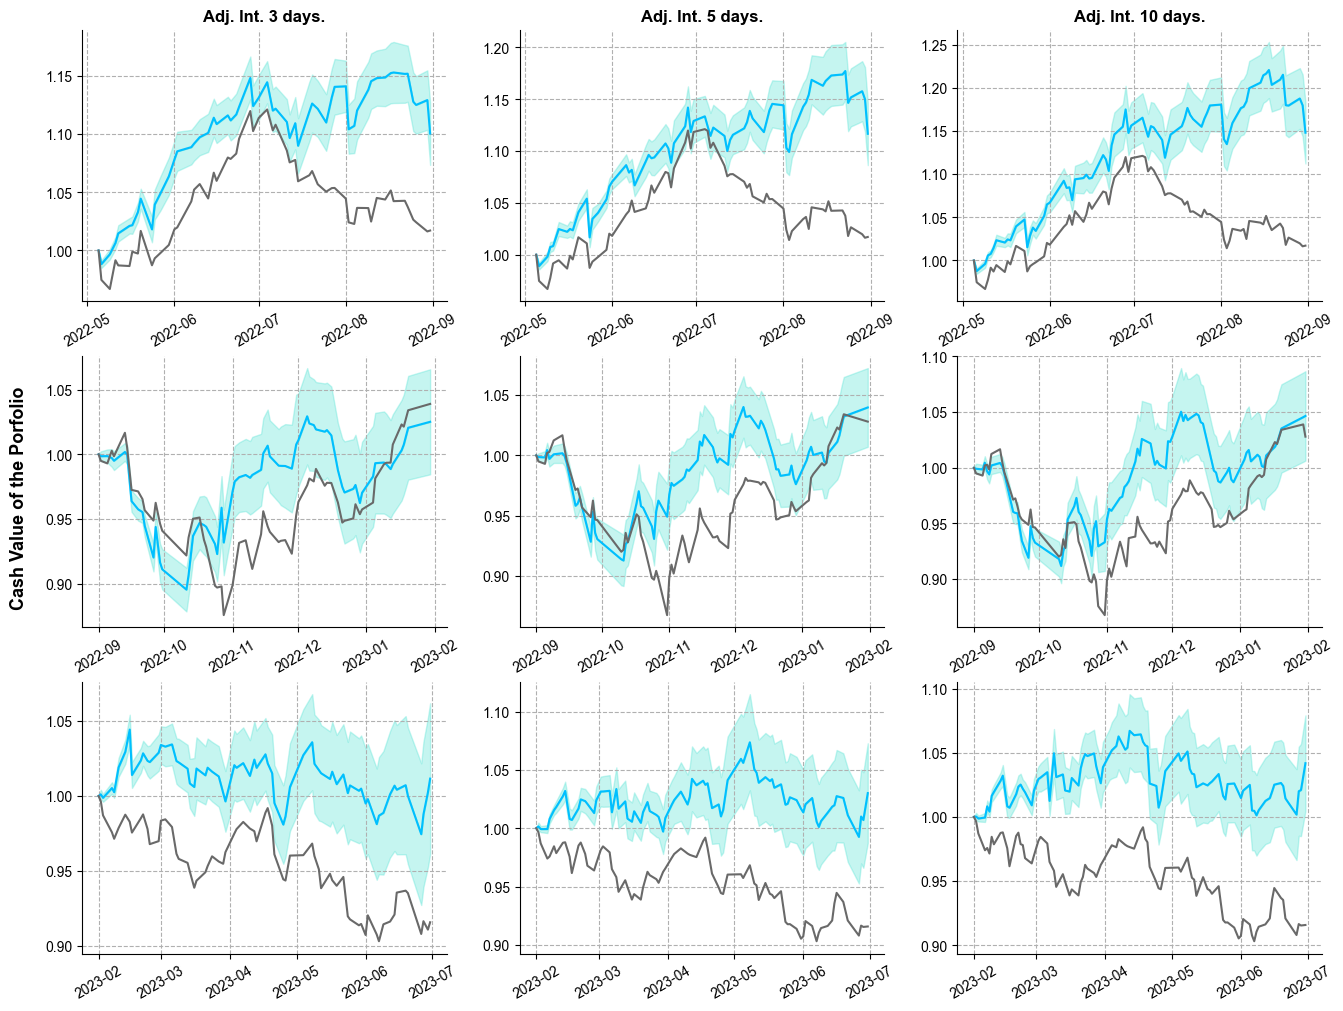

In [16]:
# 读取数据
import pandas as pd
# import numpy as np
from tqdm import notebook
#用于csv文件的存储和读取
dataset_name = 'total'
# backtime_list = [('2022-01-01', '2022-06-30', 10), ('2022-07-01', '2022-12-31', 10), ('2023-01-01', '2023-06-30', 10),
#                  ('2022-04-01', '2022-06-30', 5), ('2022-10-01', '2022-12-31', 5), ('2023-04-01', '2023-06-30', 5),
#                  ('2022-06-01', '2022-06-30', 3), ('2022-12-01', '2022-12-31', 3), ('2023-06-01', '2023-06-30', 3)]

# backtime_list = [('2022-03-01', '2022-06-30', 3), ('2022-03-01', '2022-06-30', 5), ('2022-03-01', '2022-06-30', 10),
#                  ('2022-07-01', '2022-10-31', 3), ('2022-07-01', '2022-10-31', 5), ('2022-07-01', '2022-10-31', 10),
#                  ('2022-11-01', '2023-02-28', 3), ('2022-11-01', '2023-02-28', 5), ('2022-11-01', '2023-02-28', 10)]

backtime_list = [('2022-05-01', '2022-08-31', 3), ('2022-05-01', '2022-08-31', 5), ('2022-05-01', '2022-08-31', 10),
                 ('2022-09-01', '2023-01-31', 3), ('2022-09-01', '2023-01-31', 5), ('2022-09-01', '2023-01-31', 10),
                 ('2023-02-01', '2023-06-30', 3), ('2023-02-01', '2023-06-30', 5), ('2023-02-01', '2023-06-30', 10)]
backtest_df_list = []
for i in range(len(backtime_list)):
    backtime_s, backtime_e, loop = backtime_list[i]
    backtest_df = pd.read_csv(f'backtest/{dataset_name}_backtest_timerange{backtime_s}_{backtime_e}_loop({loop}).csv',
                             parse_dates=['trade_date'], index_col=['trade_date'])
    backtest_df_list.append(backtest_df)
# 绘图
plot_multiple_subplots()

### 相同的回测周期和不同的调仓周期

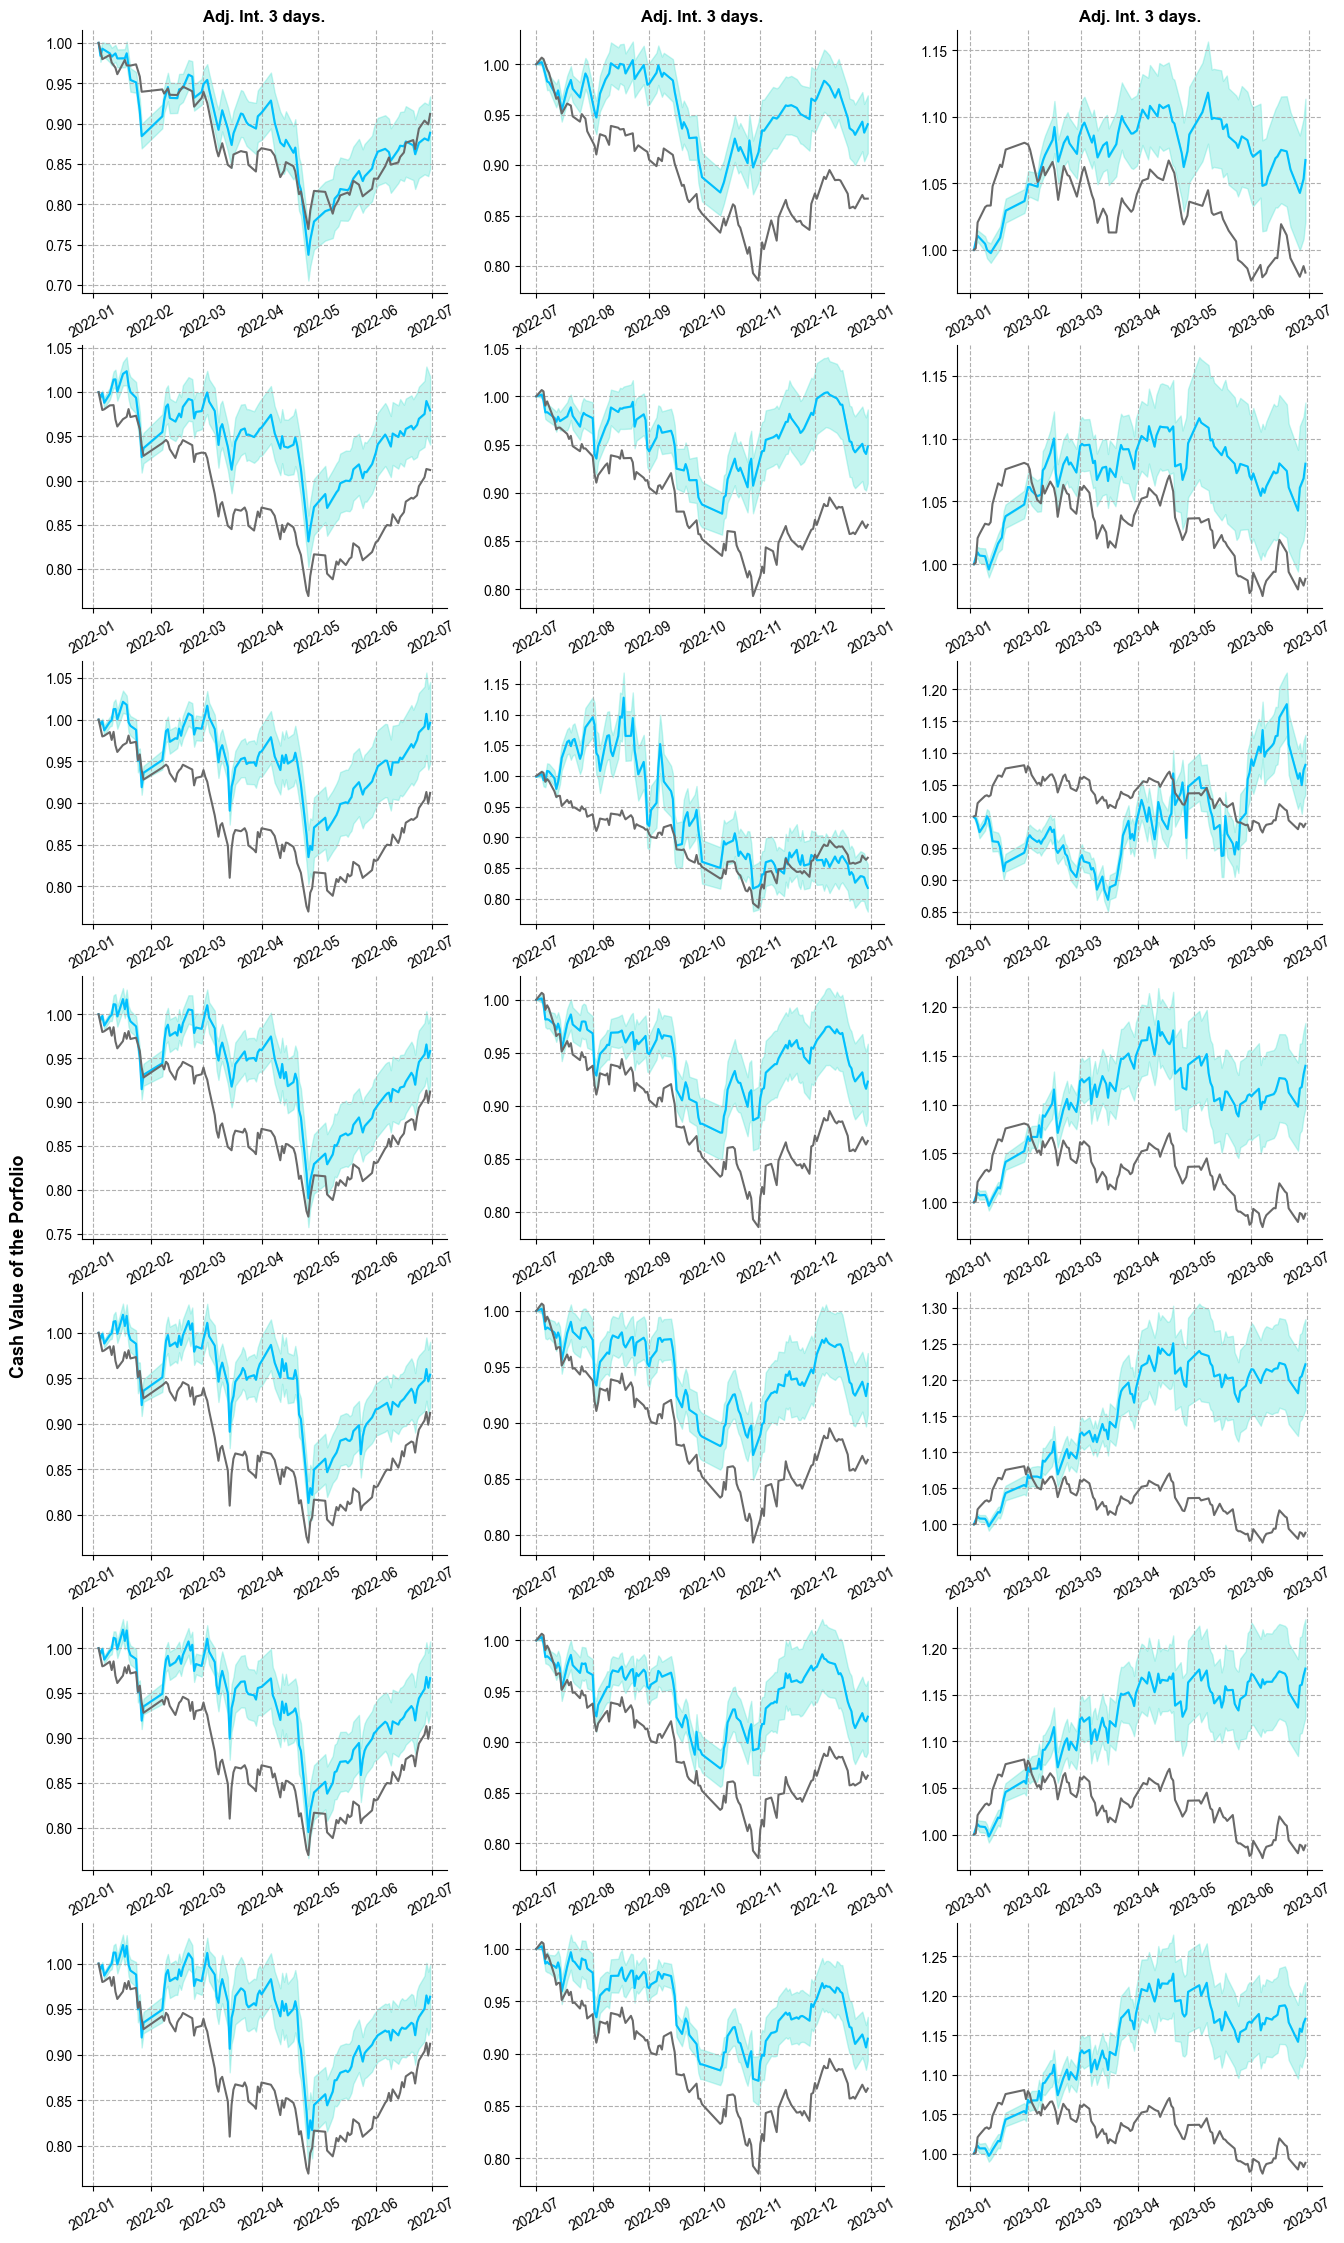

In [17]:
# 读取数据
import pandas as pd
# import numpy as np
from tqdm import notebook
#用于csv文件的存储和读取
dataset_name = 'total'
# backtime_list = [('2022-01-01', '2022-06-30', 10), ('2022-07-01', '2022-12-31', 10), ('2023-01-01', '2023-06-30', 10),
#                  ('2022-01-01', '2022-06-30', 5), ('2022-07-01', '2022-12-31', 5), ('2023-01-01', '2023-06-30', 5),
#                  ('2022-01-01', '2022-06-30', 3), ('2022-07-01', '2022-12-31', 3), ('2023-01-01', '2023-06-30', 3)]

backtime_list = [
    ('2022-01-01', '2022-06-30', 3), ('2022-07-01', '2022-12-31', 3), ('2023-01-01', '2023-06-30', 3),
    ('2022-01-01', '2022-06-30', 5), ('2022-07-01', '2022-12-31', 5), ('2023-01-01', '2023-06-30', 5),
    ('2022-01-01', '2022-06-30', 10), ('2022-07-01', '2022-12-31', 10), ('2023-01-01', '2023-06-30', 10),
    ('2022-01-01', '2022-06-30', 15), ('2022-07-01', '2022-12-31', 15), ('2023-01-01', '2023-06-30', 15),
    ('2022-01-01', '2022-06-30', 20), ('2022-07-01', '2022-12-31', 20), ('2023-01-01', '2023-06-30', 20),
    ('2022-01-01', '2022-06-30', 25), ('2022-07-01', '2022-12-31', 25), ('2023-01-01', '2023-06-30', 25),
    ('2022-01-01', '2022-06-30', 30), ('2022-07-01', '2022-12-31', 30), ('2023-01-01', '2023-06-30', 30)
    ]

backtest_df_list = []
for i in range(len(backtime_list)):
    backtime_s, backtime_e, loop = backtime_list[i]
    backtest_df = pd.read_csv(f'backtest/{dataset_name}_backtest_timerange{backtime_s}_{backtime_e}_loop({loop}).csv',
                             parse_dates=['trade_date'], index_col=['trade_date'])
    backtest_df_list.append(backtest_df)
# 绘图
plot_multiple_subplots(num=len(backtime_list), figsize=(16,28))